<a href="https://colab.research.google.com/github/KenzaxTazi/Agri-Risk/blob/master/RFECV_damons_way_Raghul_for_Mala.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#please connect your uni drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os, sys
path = '/content/drive/My Drive/Team Plants/data'
os.chdir(path)

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import time
%matplotlib inline
from tqdm import tqdm

In [0]:
from sklearn.model_selection import KFold


In [0]:
df = pd.read_csv('/content/drive/My Drive/Team Plants/data/climate_monthly_seasonal_2005_2010.csv')
df = df.sort_values(by=['lon']) #sort into vertical slices of Earth


In [0]:
df = df[abs(df['maize_a_2010'] - df['maize_a_2005']) / df['maize_a_2005'] < 1]

In [0]:
cols = df.columns.tolist()
#cols

In [0]:
df = df.drop(['Unnamed: 0', 'alloc_key', 'alloc_key', 'iso3'], axis=1)


In [0]:
nans = list(len(df) - df.count())

In [0]:
for index,i in enumerate(nans):
    if i > 8993:
        print(list(df.columns)[index], i)

SDII-01-2010 199700
SDII-02-2010 170861
SDII-03-2010 158055
SDII-04-2010 183487
SDII-05-2010 150315
SDII-06-2010 186292
SDII-07-2010 147325
SDII-08-2010 177155
SDII-09-2010 160779
SDII-10-2010 173173
SDII-11-2010 195001
SDII-12-2010 183913
SDII-01-2005 208220
SDII-02-2005 208743
SDII-03-2005 177520
SDII-04-2005 181149
SDII-05-2005 173410
SDII-06-2005 174500
SDII-07-2005 159646
SDII-08-2005 164450
SDII-09-2005 199896
SDII-10-2005 206250
SDII-11-2005 217221
SDII-12-2005 205962


In [0]:
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn import feature_selection
import time

In [0]:
!pip3 install xgboost

In [0]:
import xgboost as xgb

In [0]:
class PipelineRFE(Pipeline):

    def fit(self, X, y=None, **fit_params):
        super(PipelineRFE, self).fit(X, y, **fit_params)
        self.feature_importances_ = self.steps[-1][-1].feature_importances_
        return self

In [0]:
drop_cols = [col for col in list(df.columns) if 'SDII' in col]


In [0]:
df.drop(columns=drop_cols, inplace=True)
df.dropna(inplace=True)

In [0]:
previously_removed_columns = [
                              'ID-08-2005',
 'ID-09-2010',
 'ID-05-2010',
 'ID-06-2005',
 'TR-05-2010',
 'ID-08-2010',
 'ID-07-2010',
 'BEDD-11-2005',
 'FD-06-2005',
 'TR-04-2010',
 'FD-05-2010',
 'CFD-Q3-2005',
 'ID-06-2010',
 'ID-09-2005',
 'ID-05-2005',
 'ID-10-2005',
 'CFD-Q3-2010',
 'FD-08-2010',
 'ID-07-2005']

df.drop(columns=previously_removed_columns, inplace=True)


In [0]:
df

,lon,lat,maize_a_2010,maize_a_2005,CDD-Q1-2010,CDD-Q2-2010,CDD-Q3-2010,CDD-Q4-2010,CDD-Q1-2005,CDD-Q2-2005,CDD-Q3-2005,CDD-Q4-2005,CFD-Q1-2010,CFD-Q2-2010,CFD-Q4-2010,CFD-Q1-2005,CFD-Q2-2005,CFD-Q4-2005,CWD-Q1-2010,CWD-Q2-2010,CWD-Q3-2010,CWD-Q4-2010,CWD-Q1-2005,CWD-Q2-2005,CWD-Q3-2005,CWD-Q4-2005,WW-Q1-2010,WW-Q2-2010,WW-Q3-2010,WW-Q4-2010,WW-Q1-2005,WW-Q2-2005,WW-Q3-2005,WW-Q4-2005,WSDI-Q1-2010,WSDI-Q2-2010,WSDI-Q3-2010,WSDI-Q4-2010,WSDI-Q1-2005,WSDI-Q2-2005,...,TXn-09-2010,TXn-10-2010,TXn-11-2010,TXn-12-2010,TXn-01-2005,TXn-02-2005,TXn-03-2005,TXn-04-2005,TXn-05-2005,TXn-06-2005,TXn-07-2005,TXn-08-2005,TXn-09-2005,TXn-10-2005,TXn-11-2005,TXn-12-2005,TXx-01-2010,TXx-02-2010,TXx-03-2010,TXx-04-2010,TXx-05-2010,TXx-06-2010,TXx-07-2010,TXx-08-2010,TXx-09-2010,TXx-10-2010,TXx-11-2010,TXx-12-2010,TXx-01-2005,TXx-02-2005,TXx-03-2005,TXx-04-2005,TXx-05-2005,TXx-06-2005,TXx-07-2005,TXx-08-2005,TXx-09-2005,TXx-10-2005,TXx-11-2005,TXx-12-2005
414001,-122.541667,39.875000,4101.3,4385.1,10.000000,12.000000,90.291667,37.937500,13.729167,13.416667,73.854167,44.0,9.187500,1.458333,2.791667,8.291667,1.020833,4.958333,10.000000,5.000000,0.541667,3.833333,9.583333,5.583333,3.145833,3.000000,5.041667,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.875,0.0,0.0,0.000,0.0,7.833333,...,885.049095,876.687705,847.604382,842.198532,838.342939,850.737431,847.769757,853.284409,870.809665,877.001579,901.168394,905.258627,883.839233,869.894286,852.820122,848.494666,872.842707,875.122302,885.141848,895.154744,901.381369,917.040345,923.048886,925.003129,922.461765,908.546558,881.619907,865.437585,861.575382,875.497110,891.199723,884.600662,905.296352,915.408590,928.105370,922.245411,915.581802,904.993322,883.488799,870.147676
411940,-122.541667,40.375000,3651.7,3904.3,9.583333,11.750000,81.125000,32.000000,12.416667,13.562500,73.312500,44.0,9.208333,0.979167,2.416667,7.916667,0.729167,3.916667,10.250000,5.729167,2.375000,5.520833,9.437500,5.645833,3.687500,3.583333,4.416667,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000,0.0,0.0,0.000,0.0,7.833333,...,885.421291,875.655403,845.679726,840.353753,838.687812,851.548590,848.188393,852.529090,871.974696,877.818609,905.183076,908.943408,883.909285,870.664384,851.081006,848.335781,874.320803,874.278919,884.620881,894.812068,901.360058,917.144236,926.519885,927.693709,923.044323,909.772817,882.273358,865.538134,863.275084,877.586821,892.069475,884.708134,906.529090,914.800471,930.400097,924.540170,916.741357,905.459088,882.966962,871.803970
414948,-122.541667,39.625000,5606.8,11514.0,10.000000,12.000000,90.708333,34.437500,14.375000,13.312500,74.000000,44.0,9.125000,1.562500,3.000000,7.770833,1.166667,5.270833,10.000000,5.000000,0.395833,3.583333,9.687500,5.687500,3.000000,3.000000,5.333333,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.875,0.0,0.0,0.875,0.0,7.833333,...,884.815095,876.664870,848.307360,843.154001,838.330194,850.347001,847.711937,853.830105,870.226030,876.477704,899.723251,903.232248,883.682175,869.203252,853.673346,848.231673,871.836010,875.051573,885.202605,895.165555,901.086194,916.711864,922.026737,923.595283,922.078128,907.676381,881.104076,865.181400,860.498081,874.428772,891.055674,884.598353,904.397317,915.513103,927.028899,921.042734,915.112926,904.377054,883.359719,868.747967
412287,-122.458333,40.291667,4993.4,5338.8,9.805556,11.916667,83.013889,32.000000,12.583333,13.618056,73.534722,44.0,8.430556,0.534722,1.916667,6.416667,0.451389,2.805556,10.083333,5.173611,1.930556,4.687500,9.381944,5.479167,3.465278,3.138889,3.916667,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000,0.0,0.0,0.000,0.0,8.166667,...,888.411968,878.384579,848.447474,842.294848,840.654462,854.082958,850.670645,855.421830,874.449764,881.072639,908.867032,912.312440,887.352104,874.076461,853.812244,850.485588,875.783785,876.169220,886.766111,897.094081,904.193247,920.827209,930.002375,930.914366,925.794954,912.276189,884.677916,867.081793,865.1161

In [0]:
X = df.drop(['maize_a_2010'], axis=1).sample(n=50000, random_state=42)

y = df['maize_a_2010'].sample(n=50000, random_state=42)

In [0]:
feature_names = X.columns

In [0]:
%%time
start = time.time()
pipe = PipelineRFE([ 
                    ("RF", xgb.XGBRegressor(tree_method='gpu_hist', objective='reg:squarederror', random_state=42, error_score='raise', gamma=1, max_depth=8, min_child_weight=20, n_estimators=80))])
     
kfolds = KFold(n_splits=4, random_state=42, shuffle=False)
feature_selector_cv = feature_selection.RFECV(pipe, cv=kfolds, step=1, scoring="neg_mean_squared_error",verbose=3)
feature_selector_cv.fit(X, y)
stop=time.time()
print(f"training time: {stop-start}s")
print(f"number of features: {feature_selector_cv.n_features_}")

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Fitting estimator with 416 features.
Fitting estimator with 414 features.
Fitting estimator with 412 features.
Fitting estimator with 410 features.
Fitting estimator with 408 features.
Fitting estimator with 406 features.
Fitting estimator with 404 features.
Fitting estimator with 402 features.
Fitting estimator with 400 features.
Fitting estimator with 398 features.
Fitting estimator with 396 features.
Fitting estimator with 394 features.
Fitting estimator with 392 features.
Fitting estimator with 390 features.
Fitting estimator with 388 features.
Fitting estimator with 386 features.
Fitting estimator with 384 features.
Fitting estimator with 382 features.
Fitting estimator with 380 features.
Fitting estimator with 378 features.
Fitting estimator with 376 features.
Fitting estimator with 374 features.
Fitting estimator with 372 features.
Fitting estimator with 370 features.
Fitting estimator with 368 features.
Fitting estimator with 366 features.
Fitting estimator with 364 features.
F

In [0]:
cv_grid_rmse = np.sqrt(-feature_selector_cv.grid_scores_)
cv_grid_rmse

array([1347.12674676, 1278.63165948, 1183.22797903, 1146.65453812,
       1083.26541677, 1036.95576115, 1028.3410491 , 1022.39258739,
       1024.10320077, 1013.95908343, 1008.42648255, 1009.84658918,
       1002.42590903,  999.68867305,  996.04911349,  998.0869764 ,
        995.54701873,  991.81756767,  990.78642906,  987.90881351,
        992.51127721,  989.23021578,  982.26956417,  981.13129032,
        981.52142445,  980.20407327,  980.06490054,  975.34032632,
        974.09266018,  974.58473059,  973.24151218,  972.10934228,
        974.39138494,  972.46772087,  973.25018076,  969.79539359,
        972.72889762,  972.40533328,  973.35788866,  972.35183038,
        968.72301997,  966.12962525,  965.25420186,  969.19710669,
        969.84372008,  965.32349421,  969.82004569,  965.66352846,
        967.75662154,  963.77206966,  962.65959067,  960.85786997,
        963.65816501,  965.74133839,  963.06386815,  963.78713263,
        963.10931935,  965.05643866,  961.20558994,  959.96316

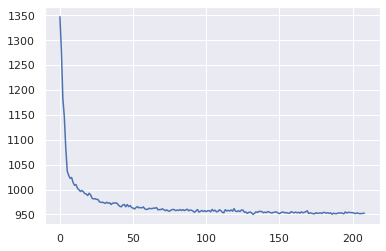

In [0]:
plt.plot(cv_grid_rmse)